In [1]:
import pandas as pd
import numpy as np
import iisignature 
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
#If you haven't install iisignature,use the code:   pip install iisignature


 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Load the dataset
stock_data = pd.read_csv("stock_details_5_years.csv")


In [3]:
#Parsing the date
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_localize(None).dt.date

In [4]:
#Calculating daily returns
stock_data['Return'] = stock_data.groupby('Company')['Close'].pct_change()
stock_data['OReturn'] = stock_data.groupby('Company')['Open'].pct_change()
stock_data.dropna(subset=['Return'], inplace=True)
stock_data.dropna(subset=['OReturn'], inplace=True)








In [5]:
#Delete useless company
target_date = pd.Timestamp('2022-02-01')
valid_companies = stock_data.loc[stock_data['Date'] == target_date, 'Company'].unique()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [6]:
#Retain company data that exists on the target date
stock_data = stock_data[stock_data['Company'].isin(valid_companies)]


In [7]:
#Data for simulate
start_date = pd.Timestamp('2022-02-01')
end_date = pd.Timestamp('2022-03-04')

#Get data for a specific time period
simulate_stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]








In [8]:
unique_dates_count = simulate_stock_data['Date'].nunique()
print(unique_dates_count)

unique_companys_count = simulate_stock_data['Company'].nunique()
print(unique_companys_count)


23
486


In [9]:
#Calculate mean &std of data
company_stats_C = simulate_stock_data.groupby('Company')['Return'].agg(['mean', 'std']).rename(columns={'mean': 'cmiu', 'std': 'csigma'})
company_stats_O = simulate_stock_data.groupby('Company')['OReturn'].agg(['mean', 'std']).rename(columns={'mean': 'omiu', 'std': 'osigma'})


#Simulate the return and open return
np.random.seed(2024)
simulate_stock_data = simulate_stock_data.merge(company_stats_C, on='Company')
simulate_stock_data['sim_creturn'] = simulate_stock_data.apply(
    lambda row: np.mean([np.random.normal(row['cmiu'], row['csigma']) for _ in range(100)]), axis=1
)
simulate_stock_data = simulate_stock_data.drop(columns=['cmiu', 'csigma'])


np.random.seed(2024)
simulate_stock_data = simulate_stock_data.merge(company_stats_O, on='Company')
simulate_stock_data['sim_oreturn'] = simulate_stock_data.apply(
    lambda row: np.mean([np.random.normal(row['omiu'], row['osigma']) for _ in range(100)]), axis=1
)
simulate_stock_data = simulate_stock_data.drop(columns=['omiu', 'osigma'])

simulate_stock_data['sim_Close'] = np.nan
simulate_stock_data['sim_Open'] = np.nan


# Sort the data by Company and Date
simulate_stock_data = simulate_stock_data.sort_values(by=['Company', 'Date'])

# Function to calculate simulated close and open prices
def calculate_sim(group):
    group = group.sort_values(by='Date').reset_index(drop=True)
    for i in range(len(group)):
        if i == 0:
            group.at[i, 'sim_Close'] = group.at[i, 'Close'] * (1 + group.at[i, 'sim_creturn'])
            group.at[i, 'sim_Open'] = group.at[i, 'Open'] * (1 + group.at[i, 'sim_oreturn'])
        else:
            group.at[i, 'sim_Close'] = group.at[i - 1, 'sim_Close'] * (1 + group.at[i, 'sim_creturn'])
            group.at[i, 'sim_Open'] = group.at[i - 1, 'sim_Open'] * (1 + group.at[i, 'sim_oreturn'])
    return group

# Apply the function to each group of companies
simulate_stock_data = simulate_stock_data.groupby('Company').apply(calculate_sim).reset_index(drop=True)


In [10]:
simulate_stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,Return,OReturn,sim_creturn,sim_oreturn,sim_Close,sim_Open
0,2022-02-01,138.838766,139.569866,136.783796,139.332748,1655900,0.0,0.0,A,0.012274,0.023376,-0.000830,0.000339,139.217139,138.885787
1,2022-02-02,139.293248,143.017866,139.085768,142.504135,1475700,0.0,0.0,A,0.022761,0.003273,-0.001888,-0.000632,138.954306,138.797978
2,2022-02-03,140.291067,142.049644,139.312976,140.083588,914300,0.0,0.0,A,-0.016986,0.007163,0.000450,0.001513,139.016882,139.008001
3,2022-02-04,139.777345,140.636885,137.989130,139.421677,1087400,0.0,0.0,A,-0.004725,-0.003662,-0.001488,-0.000265,138.810022,138.971121
4,2022-02-07,139.797100,140.775191,138.127436,138.680695,1444100,0.0,0.0,A,-0.005315,0.000141,-0.001125,0.000068,138.653857,138.980536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11173,2022-02-28,189.714061,192.630623,189.073607,190.807770,2220200,0.0,0.0,ZTS,-0.005444,0.005536,-0.000750,-0.000342,192.993861,196.484868
11174,2022-03-01,191.063953,192.137951,188.492260,189.714050,1669100,0.0,0.0,ZTS,-0.005732,0.007115,0.000797,0.001890,193.147716,196.856188
11175,2022-03-02,190.443202,194.374645,190.315105,193.192261,1355300,0.0,0.0,ZTS,0.018334,-0.003249,-0.000607,-0.000136,193.030474,196.829404
11176,2022-03-03,194.256375,194.394319,191.596006,192.995163,1052200,0.0,0.0,ZTS,-0.001020,0.020023,0.000318,0.001199,193.091946,197.065427


In [11]:
# Def fuc to calculate signature 
def calculate_signature(data):
    company = data['Company'].iloc[0]
    date = data['Date'].iloc[0]
    company_data = simulate_stock_data[(simulate_stock_data['Company'] == company) & (simulate_stock_data['Date'] <= date)]
    if len(company_data) > 0:
        close_values = company_data['sim_Close'].values.reshape(-1, 1)  #Convert to a 2D array
        volume_values = company_data['sim_Open'].values.reshape(-1, 1)   #Convert to a 2D array
        #Compute first-order and second-order signatures
        signature_close_1 = iisignature.sig(close_values, 1)
        signature_volume_1 = iisignature.sig(volume_values, 1)
        signature_close_2 = iisignature.sig(close_values, 2)
        signature_volume_2 = iisignature.sig(volume_values, 2)
        #Concatenate signature data
        signature = np.concatenate((signature_close_1, signature_volume_1, signature_close_2, signature_volume_2), axis=None)
        return pd.Series({'Signature': signature})
    else:
        return pd.Series({'Signature': (0,0,0,0,0,0)})

#Calculate the signature
signatures = simulate_stock_data.groupby(['Company', 'Date']).apply(calculate_signature)
simulate_stock_data = simulate_stock_data.merge(signatures, left_on=['Company', 'Date'], right_index=True)


In [12]:
#Change 1 col into 6
simulate_stock_data[['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']] = pd.DataFrame(simulate_stock_data['Signature'].tolist(), index=simulate_stock_data.index)

#Delete old col
simulate_stock_data = simulate_stock_data.drop(columns=['Signature'])




In [13]:
simulate_stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,Return,...,sim_creturn,sim_oreturn,sim_Close,sim_Open,Signature1,Signature2,Signature3,Signature4,Signature5,Signature6
0,2022-02-01,138.838766,139.569866,136.783796,139.332748,1655900,0.0,0.0,A,0.012274,...,-0.000830,0.000339,139.217139,138.885787,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-02-02,139.293248,143.017866,139.085768,142.504135,1475700,0.0,0.0,A,0.022761,...,-0.001888,-0.000632,138.954306,138.797978,-0.262834,-0.087809,-0.262834,0.034541,-0.087809,0.003855
2,2022-02-03,140.291067,142.049644,139.312976,140.083588,914300,0.0,0.0,A,-0.016986,...,0.000450,0.001513,139.016882,139.008001,-0.200257,0.122214,-0.200257,0.020051,0.122214,0.007468
3,2022-02-04,139.777345,140.636885,137.989130,139.421677,1087400,0.0,0.0,A,-0.004725,...,-0.001488,-0.000265,138.810022,138.971121,-0.407118,0.085334,-0.407118,0.082872,0.085334,0.003641
4,2022-02-07,139.797100,140.775191,138.127436,138.680695,1444100,0.0,0.0,A,-0.005315,...,-0.001125,0.000068,138.653857,138.980536,-0.563282,0.094748,-0.563282,0.158644,0.094748,0.004489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11173,2022-02-28,189.714061,192.630623,189.073607,190.807770,2220200,0.0,0.0,ZTS,-0.005444,...,-0.000750,-0.000342,192.993861,196.484868,-2.442460,-0.951001,-2.442460,2.982806,-0.951001,0.452201
11174,2022-03-01,191.063953,192.137951,188.492260,189.714050,1669100,0.0,0.0,ZTS,-0.005732,...,0.000797,0.001890,193.147716,196.856188,-2.288605,-0.579681,-2.288605,2.618857,-0.579681,0.168015
11175,2022-03-02,190.443202,194.374645,190.315105,193.192261,1355300,0.0,0.0,ZTS,0.018334,...,-0.000607,-0.000136,193.030474,196.829404,-2.405848,-0.606465,-2.405848,2.894051,-0.606465,0.183900
11176,2022-03-03,194.256375,194.394319,191.596006,192.995163,1052200,0.0,0.0,ZTS,-0.001020,...,0.000318,0.001199,193.091946,197.065427,-2.344375,-0.370442,-2.344375,2.748048,-0.370442,0.068614


In [14]:
#Extract true values
true_y = simulate_stock_data[simulate_stock_data['Date'] == pd.Timestamp('2022-03-04').date()][['Company', 'sim_Close']].rename(columns={'sim_Close': 'true_y'})

#Lasso regression for each company
results = []

for company in valid_companies:
    company_data = simulate_stock_data[simulate_stock_data['Company'] == company]
    
    train_x = company_data[(company_data['Date'] >= pd.Timestamp('2022-02-01').date()) & (company_data['Date'] <= pd.Timestamp('2022-03-02').date())][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    train_y = company_data[(company_data['Date'] >= pd.Timestamp('2022-02-03').date()) & (company_data['Date'] <= pd.Timestamp('2022-03-03').date())]['sim_Close']
    
    #Ensure train_x and train_y are aligned
    train_x = train_x.iloc[1:].reset_index(drop=True)
    train_y = train_y.reset_index(drop=True)
    
    #Perform LassoCV
    lasso = LassoCV(cv=5, random_state=2024)
    lasso.fit(train_x, train_y)
    
    #Predict the value
    test_x = company_data[company_data['Date'] == pd.Timestamp('2022-03-03').date()][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    predict_y = lasso.predict(test_x)[0]
    
    results.append({'Company': company, 'predicted_y': predict_y})

#Create results DataFrame
results_df = pd.DataFrame(results)

#Merge true values with predictions
sim_result = true_y.merge(results_df, on='Company')



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17886150117233512, tolerance: 0.17817299434358944
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18183161043295826, tolerance: 0.17817299434358944
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46953245193193993, tolerance: 0.2741871948298783
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038561496779594695, tolerance: 0.00027856747681395
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004940003588943809, tolerance: 0.00027856747681395
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005272630494294744, tolerance: 0.00027856747681395
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.529e+00, tolerance: 2.085e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05730589735725289, tolerance: 0.0494468427272849
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07243830366231663, tolerance: 0.0494468427272849
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-pack

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.489815403750356, tolerance: 0.6575272780506395
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.24382330169675, tolerance: 0.6575272780506395
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.067877722753309, tolerance: 0.6575272780506395
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-02, tolerance: 1.267e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7028764040112492, tolerance: 1.686541097266671
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.686953773298569, tolerance: 1.686541097266671
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.465e+02, tolerance: 2.428e+01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025462985803825777, tolerance: 0.0022120021745345468
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012336824050853457, tolerance: 0.004266057795144856
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014101789184992608, tolerance: 0.0009576850570926688
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021511361374634275, tolerance: 0.0009576850570926688
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001460248799519448, tolerance: 0.0009576850570926688
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0075238628596172585, tolerance: 0.006838756804928069
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032793341732581194, tolerance: 0.023288554741168862
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037751750947512264, tolerance: 0.023288554741168862
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.088e-03, tolerance: 1.138e-03
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.823e-03, tolerance: 1.771e-03
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.177e-03, toleranc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005122332175722111, tolerance: 0.0003635965706379742
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003033708713427452, tolerance: 0.00023115117639252515
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005305750238531193, tolerance: 0.00023115117639252515
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10446684269371609, tolerance: 0.07216020680180125
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10758730783847881, tolerance: 0.07216020680180125
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1055672104972345, tolerance: 0.07216020680180125
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009580247759331528, tolerance: 0.0005830055265088033
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014764849501640587, tolerance: 0.0005830055265088033
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016721617180626147, tolerance: 0.0005830055265088033
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.680e-02, tolerance: 1.968e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00027650225752448576, tolerance: 0.00019353508515550347
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035779536813496104, tolerance: 0.00019353508515550347
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006911106499209174, tolerance: 0.0001461863960635418
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010091116611916917, tolerance: 8.317063381344466e-05
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015529357514720843, tolerance: 8.317063381344466e-05
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022563268751049637, tolerance: 0.00019519066386699572
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.131e-02, tolerance: 7.129e-03
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.695e-03, tolerance: 1.826e-03
  model = cd_fast.enet_coor

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005676120387278605, tolerance: 0.004807253696078018
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006717097967214647, tolerance: 0.004807253696078018
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007272600001000384, tolerance: 0.004807253696078018
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008319989763054259, tolerance: 0.0007548929245424706
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008276366790352097, tolerance: 0.0007548929245424706
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007986285918473585, tolerance: 0.0007548929245424706
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017181230477634646, tolerance: 0.00907118462045402
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035021336766220657, tolerance: 0.033675182933184104
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05593671539807943, tolerance: 0.033675182933184104
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008851780912508267, tolerance: 0.0006056132368913652
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012812101532423958, tolerance: 0.0006056132368913652
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014594844653375016, tolerance: 0.0006056132368913652
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004336809894534888, tolerance: 0.0016703526363324144
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0058558072800452, tolerance: 0.0016703526363324144
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006243264191435172, tolerance: 0.0016703526363324144
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12500224087264655, tolerance: 0.09327418828816411
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13196136232039635, tolerance: 0.09327418828816411
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07121151897675393, tolerance: 0.05332240578651414
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

In [19]:
#Calcilate difference
sim_result["difference"] = (sim_result["true_y"] - sim_result["predicted_y"]).abs()
sim_result["difference_percentage"] = (sim_result["difference"] / sim_result["true_y"]) * 100

#Sort by difference
sim_result_sorted = sim_result.sort_values(by="difference")


#Print first and last 10 lines
print("10 lines with lowest difference:")
print(sim_result_sorted.head(10))

# 打印后十行
print("\n 10 lines with highest difference:")
print(sim_result_sorted.tail(10))


10 lines with lowest difference:
    Company      true_y  predicted_y  difference  difference_percentage
408     SYM    9.925247     9.925158    0.000089               0.000899
375     SAN    2.887566     2.888288    0.000721               0.024986
280     MFG    2.650961     2.652289    0.001328               0.050102
3      ABEV    2.589115     2.587761    0.001354               0.052279
104     COR  144.917096   144.915345    0.001751               0.001208
265     LYG    2.123517     2.121377    0.002140               0.100797
461      VZ   49.598110    49.595115    0.002995               0.006039
445     UMC    7.976053     7.972946    0.003107               0.038954
71      BSX   44.597190    44.594082    0.003109               0.006971
369     ROL   33.357980    33.361715    0.003734               0.011195

 10 lines with highest difference:
    Company       true_y  predicted_y  difference  difference_percentage
44      AZO  1954.053425  1948.344732    5.708693               0.

In [16]:
#Calculate overall R² score
overall_r2_score = r2_score(sim_result['true_y'], sim_result['predicted_y'])
print(f"R² score: {overall_r2_score}")

R² score: 0.9999456909413212


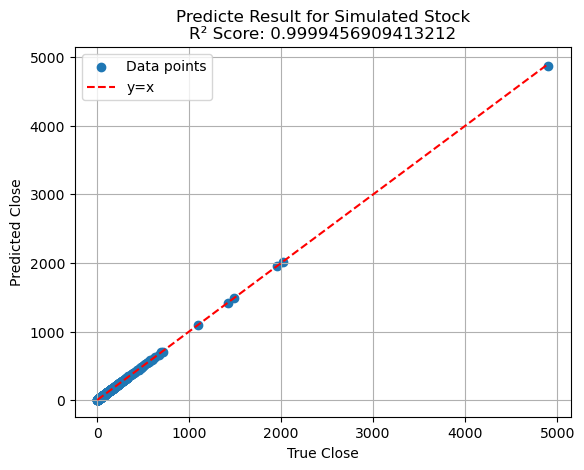

In [17]:
#Plot
plt.scatter(sim_result['true_y'], sim_result['predicted_y'], label='Data points')
plt.xlabel('True Close')
plt.ylabel('Predicted Close')
plt.title(f'Predicte Result for Simulated Stock\nR² Score: {overall_r2_score}')

plt.plot([sim_result['true_y'].min(), sim_result['true_y'].max()], [sim_result['true_y'].min(), sim_result['true_y'].max()], 'r--', label='y=x')
plt.legend()
plt.grid(True)
plt.show()